# The Wilson-Cowan model

The Wilson–Cowan model considers a homogeneous population of interconnected neurons of excitatory and inhibitory subtypes. All cells receive the same number of excitatory and inhibitory afferents, that is, all cells receive the same average excitation, $x(t)$. The target is to analyze the evolution in time of number of excitatory and inhibitory cells firing at time $t$,
$E(t)$ and $I(t)$ respectively.


This notebook demonstrates Wilson–Cowan oscillators at three scales: a single node, a 1D input sweep to reveal a bifurcation diagram, and a multi‑region brain network with delayed coupling.

Model sketch (E/I rates):

$$
\tau_E \dot E = -E + S_E(w_{EE} E - w_{EI} I + I_E + \xi_E)
$$
$$
\tau_I \dot I = -I + S_I(w_{IE} E - w_{II} I + I_I + \xi_I)
$$

where $S_{E/I}(\cdot)$ are sigmoids and $\xi$ denotes OU noise. We use `brainmass.WilsonCowanModel`, which encapsulates these dynamics and exposes the excitatory rate `rE`.

What we will do:
- Configure the simulation step `dt` and plotting defaults.
- Simulate a single oscillator and visualize `rE(t)`.
- Sweep a constant input to map min/max `rE` vs input (bifurcation view).
- Build a network using structural coupling and delays; inspect FC and activity traces.

Tips:
- Longer transients improve steady‑state estimates; adjust steps if needed.
- Noise scale `sigma` affects oscillation emergence and variability.

In [ ]:
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

import brainmass
from datasets import Dataset

plt.rcParams['image.cmap'] = 'plasma'

In [2]:
brainstate.environ.set(dt=0.1 * u.ms)

Environment:
- `dt = 0.1 ms` sets the integration time step for all updates.
- We will rely on `brainstate.transform.for_loop` to advance the model efficiently.

## Single node simulation

We instantiate one Wilson–Cowan node with OU noise on both E and I. The `step_run(i)` helper advances the model one time step with a proper `(i, t)` context. The node returns the current excitatory rate `rE`.

In [3]:
node = brainmass.WilsonCowanModel(
    1,
    noise_E=brainmass.OUProcess(1, sigma=0.01, init=brainstate.init.ZeroInit()),
    noise_I=brainmass.OUProcess(1, sigma=0.01, init=brainstate.init.ZeroInit()),
)
brainstate.nn.init_all_states(node)


def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return node.update(0.1)


indices = np.arange(10000)
exec_activity = brainstate.transform.for_loop(step_run, indices)

The trace below shows `rE(t)` over time. With small noise and constant drive, the oscillator may settle to a fixed point or a limit cycle depending on parameters.

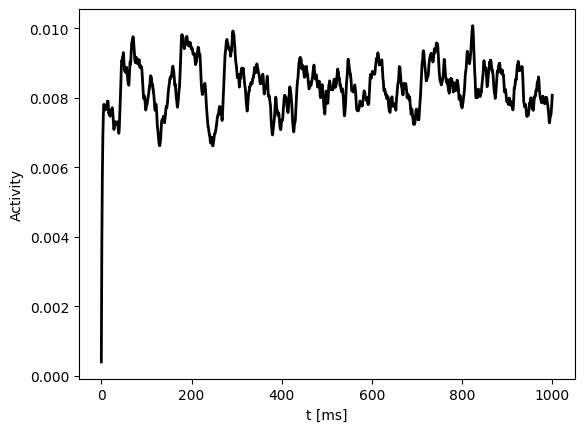

In [4]:
plt.plot(indices * brainstate.environ.get_dt(), exec_activity, c='k', lw=2)
plt.xlabel("t [ms]")
plt.ylabel("Activity")
plt.show()

## Bifurcation diagram

Let's draw a simple one-dimensional bifurcation diagram of this model to orient ourselves in the parameter space.


In [5]:
# these are the different input values that we want to scan
exc_inputs = np.arange(0, 5.5, 0.05)

We sweep a constant excitatory input across multiple independent nodes (one input per node). For each input value we simulate, then record the minimum and maximum of `rE` over time. Plotting min/max against input visualizes fixed points (lines collapsing) versus oscillatory regimes (min/max bands).

Notes:
- Increase simulation duration to better capture oscillation envelopes.
- You can reduce `exc_inputs` resolution for speed during exploration.

In [ ]:
nodes = brainmass.WilsonCowanModel(exc_inputs.size)
brainstate.nn.init_all_states(nodes)


def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return nodes.update(exc_inputs)


indices = np.arange(10000)
exec_activity = brainstate.transform.for_loop(step_run, indices)

In [7]:
max_exc = exec_activity.max(axis=0)
min_exc = exec_activity.min(axis=0)

The resulting diagram shows how steady‑state activity or oscillation amplitude varies with the external excitatory drive.

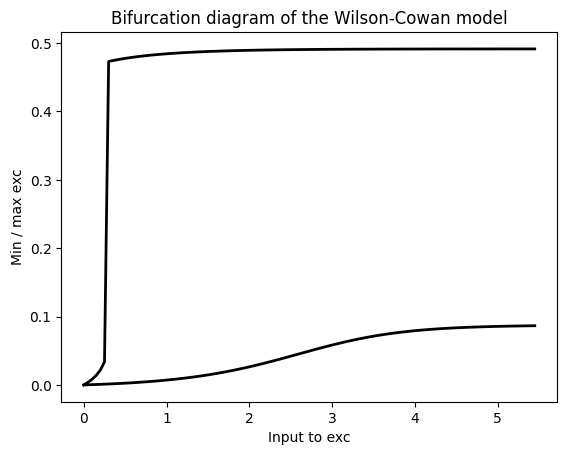

In [8]:
plt.plot(exc_inputs, max_exc, c='k', lw=2)
plt.plot(exc_inputs, min_exc, c='k', lw=2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")
plt.show()

## Brain network

We now couple many Wilson–Cowan nodes according to structural connectivity (weights `Cmat`) and distances `Dmat` from the `hcp` dataset. Delays are derived from distances and a `signal_speed`. We use diffusive coupling on `rE` with per‑edge delays and scale the interaction by a global gain `k`.

In [9]:
hcp = Dataset('hcp')

Loading dataset hcp from D:\codes\projects\brainmass\examples\datasets\hcp.
Dataset hcp loaded.


In [10]:
class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2., k=1.):
        super().__init__()

        conn_weight = hcp.Cmat
        np.fill_diagonal(conn_weight, 0)
        delay_time = hcp.Dmat / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.arange(conn_weight.shape[1])
        indices_ = np.tile(np.expand_dims(indices_, axis=0), (conn_weight.shape[0], 1))

        self.node = brainmass.WilsonCowanModel(
            80,
            noise_E=brainmass.OUProcess(80, sigma=0.01, init=brainstate.init.ZeroInit()),
            noise_I=brainmass.OUProcess(80, sigma=0.01, init=brainstate.init.ZeroInit()),
        )
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('rE', (delay_time * u.ms, indices_), init=brainstate.init.Uniform(0, 0.05)),
            self.node.prefetch('rE'),
            conn_weight,
            k=k
        )

    def update(self):
        current = self.coupling()
        rE = self.node(current)
        return rE

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

Network dynamics:
- `prefetch_delay('rE', (delay_time, indices))` constructs a delayed view of E‑rates along edges.
- `DiffusiveCoupling` computes inputs from delayed neighbors and scales by `k`.
- The node integrates these inputs and returns `rE`.

In [11]:
net = Network()
brainstate.nn.init_all_states(net)
indices = np.arange(0, 6e3 // (brainstate.environ.get_dt() / u.ms))
exes = brainstate.transform.for_loop(net.step_run, indices)

We compute functional connectivity (pairwise correlation) from the simulated `rE` matrix and plot it alongside sample time series. Stronger structure‑function correspondence typically emerges around specific `k` and delay regimes.

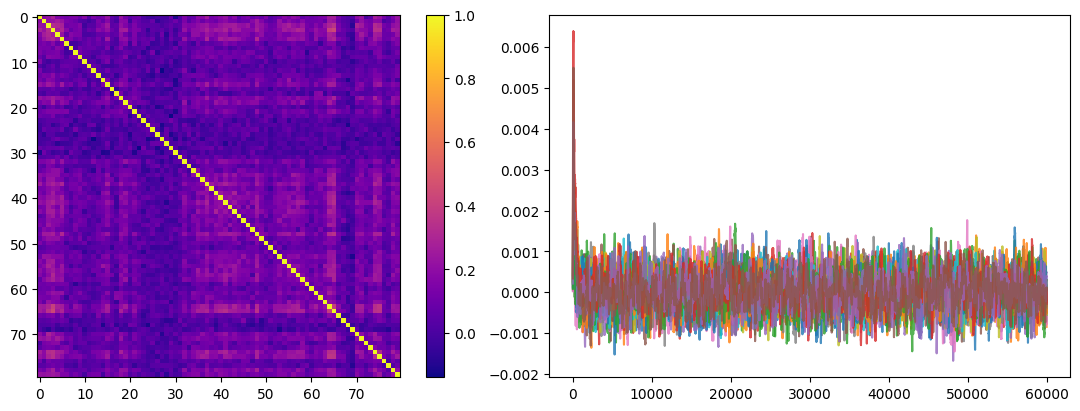

In [12]:
fig, gs = braintools.visualize.get_figure(1, 2, 4, 6)
ax1 = fig.add_subplot(gs[0, 0])
fc = braintools.metric.functional_connectivity(exes)
ax = ax1.imshow(fc)
plt.colorbar(ax, ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(indices, exes[:, ::5], alpha=0.8)
plt.show()